In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 8.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 15.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 17.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [16]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score, cohen_kappa_score, davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna as op

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/TS-S3-Ep5/train.csv'
file_key_2 = 'Tabular-Playground-Series/TS-S3-Ep5/test.csv'
file_key_3 = 'Tabular-Playground-Series/TS-S3-Ep5/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

In [2]:
train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


In [3]:
train.shape

(2056, 13)

# Clustering 

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


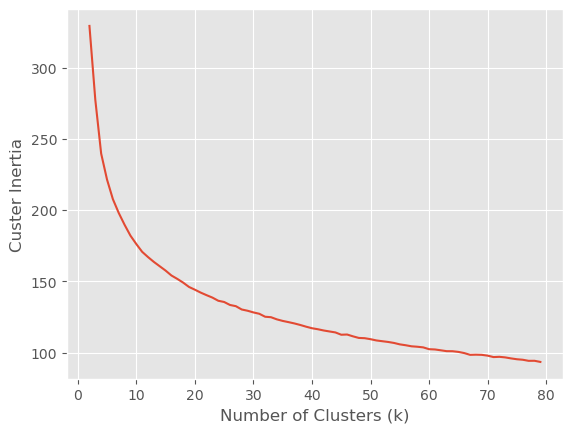

In [8]:
scaler = MinMaxScaler()

X = train.drop(columns = ['Id', 'quality'], axis = 1)
X_trans = scaler.fit_transform(X)

from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

## Defining the number of clusters to be considered
krange = list(range(2, 80))

## Defining lists to store scores
CH_scores, DB_scores, silhouette_scores = list(), list(), list()
inertias = list()

for i in krange:
    print(i)
    ## Here we define the k-means model
    cluster_md = KMeans(n_clusters = i, n_init = 20).fit(X_trans)
    cluster_assignments = cluster_md.labels_
    inertias.append(cluster_md.inertia_)
    
    ## Here we extract CH, DB and silhoutte scores
    CH = calinski_harabasz_score(X_trans, cluster_assignments)
    DB = davies_bouldin_score(X_trans, cluster_assignments)
    silhouette = silhouette_score(X_trans, cluster_assignments)
    
    ## Storing scores
    CH_scores.append(CH)
    DB_scores.append(DB)
    silhouette_scores.append(silhouette)

plt.plot(krange, inertias)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Custer Inertia')
plt.show()
# fig.savefig('V1_V28_clusters.pdf')


# ## Visualizing the scores    
# fig, axs = plt.subplots(1, 3, figsize = (20, 8))
# axs[0].plot(krange, CH_scores)
# axs[0].set_xlabel('Number of Clusters (k)')
# axs[0].set_ylabel('CH-Score')
# axs[0].grid()

# axs[1].plot(krange, DB_scores)
# axs[1].set_xlabel('Number of Clusters (k)')
# axs[1].set_ylabel('DB-Score')
# axs[1].grid()

# axs[2].plot(krange, silhouette_scores)
# axs[2].set_xlabel('Number of Clusters (k)')
# axs[2].set_ylabel('Silhouette-Score')
# axs[2].grid()

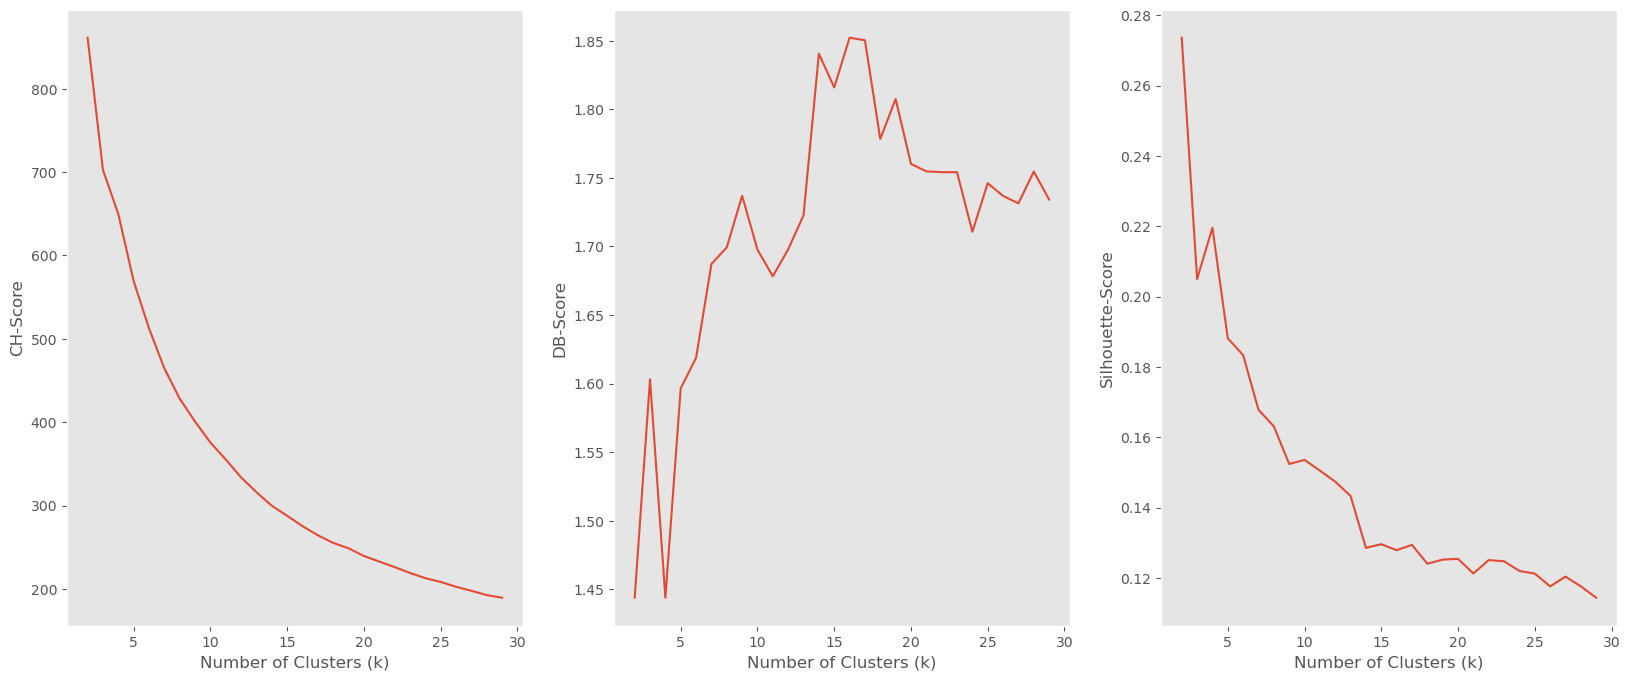

In [5]:
fig, axs = plt.subplots(1, 3, figsize = (20, 8))
axs[0].plot(krange, CH_scores)
axs[0].set_xlabel('Number of Clusters (k)')
axs[0].set_ylabel('CH-Score')
axs[0].grid()

axs[1].plot(krange, DB_scores)
axs[1].set_xlabel('Number of Clusters (k)')
axs[1].set_ylabel('DB-Score')
axs[1].grid()

axs[2].plot(krange, silhouette_scores)
axs[2].set_xlabel('Number of Clusters (k)')
axs[2].set_ylabel('Silhouette-Score')
axs[2].grid()

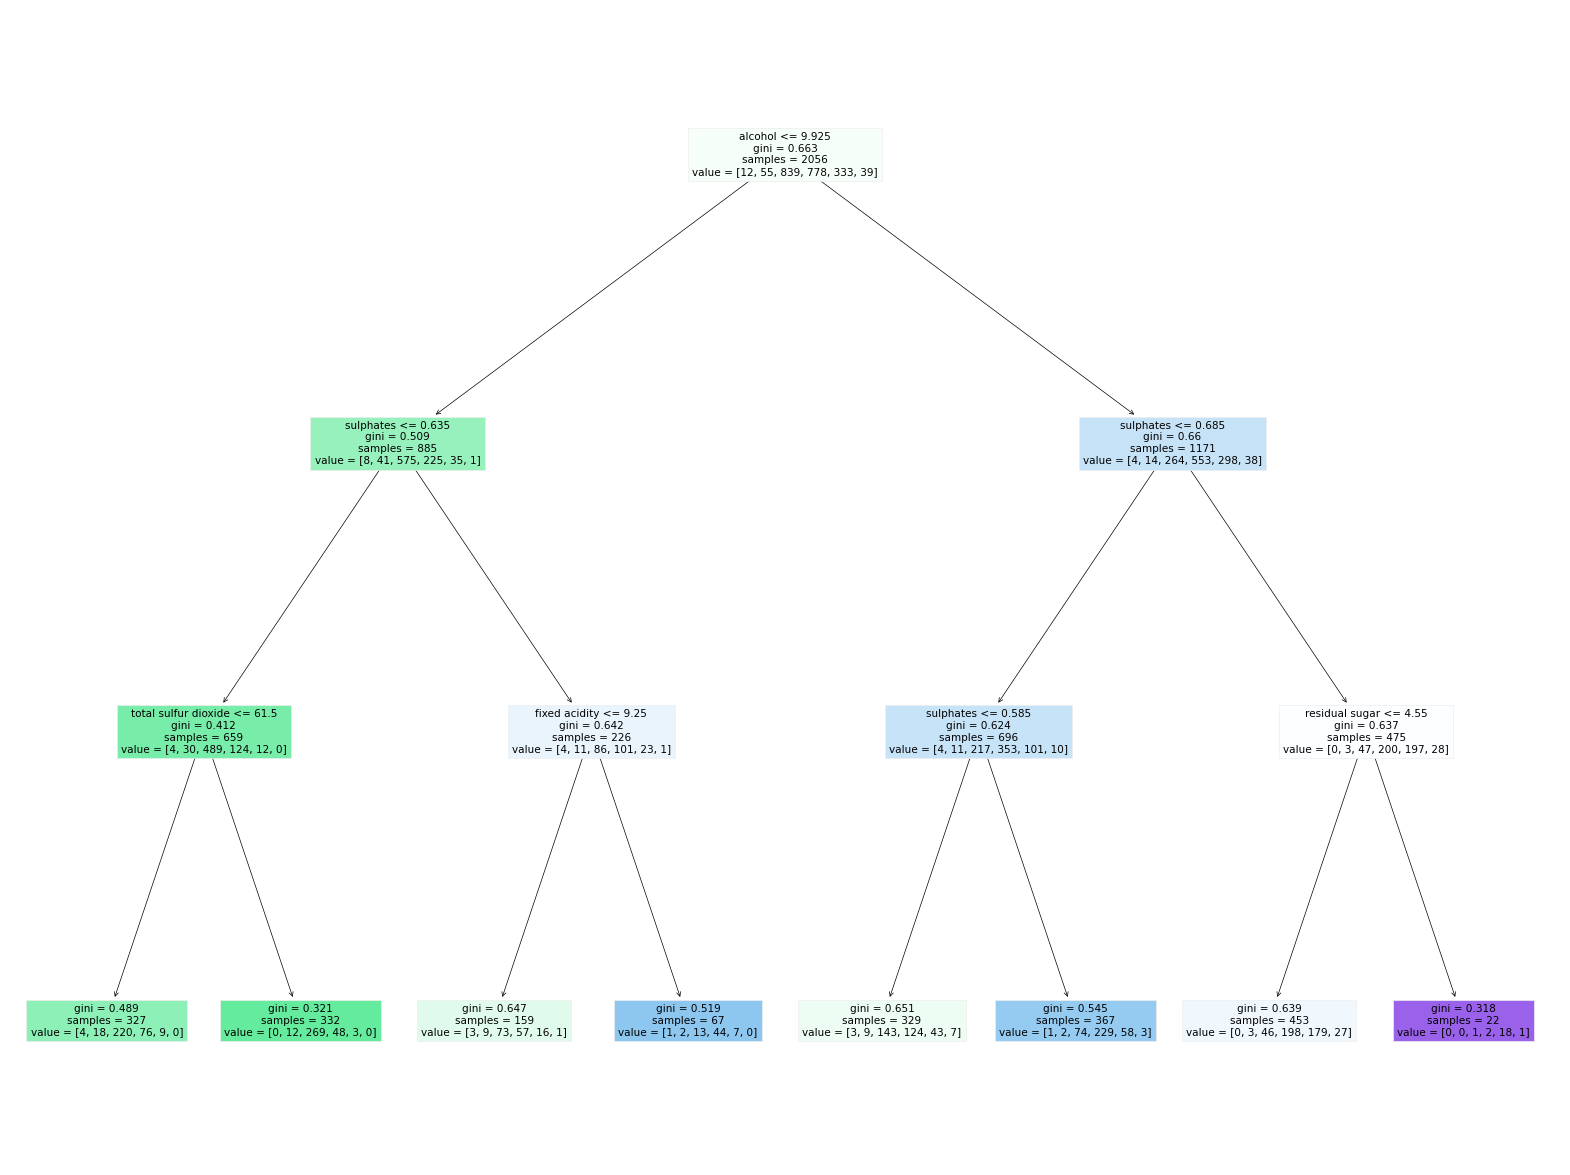

In [30]:
## Defining the input and target variables
X = train.drop(columns = ['Id', 'quality'], axis = 1)
Y = train['quality']

# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X, Y)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 15))
plot_tree(tree_md, feature_names = X.columns, filled = True);

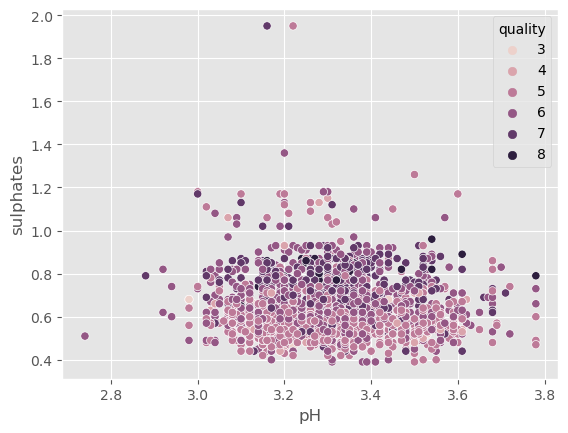

In [9]:
sns.scatterplot(x = 'pH', y = 'sulphates', hue = 'quality', data = train);

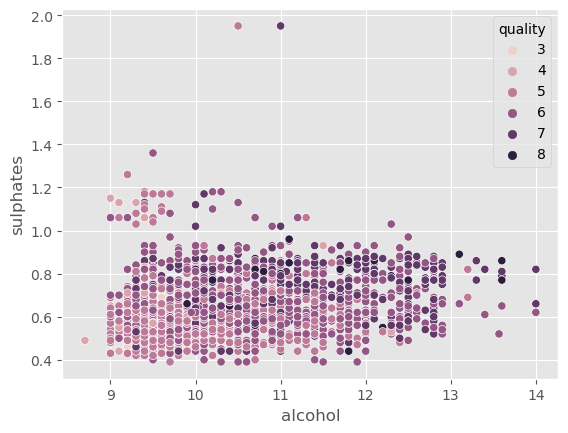

In [11]:
sns.scatterplot(x = 'alcohol', y = 'sulphates', hue = 'quality', data = train);

In [33]:
train[train['alcohol'] < 9]['quality'].value_counts()

4    1
Name: quality, dtype: int64

In [34]:
train[train['alcohol'] < 9]

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
234,234,7.7,0.725,0.12,1.9,0.078,21.0,66.0,0.9963,3.37,0.49,8.7,4


In [37]:
train[train['alcohol'] > 13]['quality'].value_counts()

7    6
6    5
8    4
5    2
Name: quality, dtype: int64

In [38]:
test[test['alcohol'] > 13]

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
8,2064,6.3,0.47,0.32,1.90,0.069,18.0,85.0,0.99580,3.39,0.55,14.000000
36,2092,8.5,0.32,0.50,2.00,0.097,12.0,31.0,0.99655,3.38,0.86,13.600000
151,2207,5.6,0.31,0.01,1.80,0.066,13.0,31.0,0.99160,3.69,0.69,14.000000
211,2267,5.6,0.42,0.09,2.10,0.068,3.0,12.0,0.99334,3.43,0.76,14.000000
376,2432,8.4,0.58,0.15,2.65,0.084,13.0,49.0,0.99586,3.22,0.52,13.100000
517,2573,6.7,0.45,0.24,1.70,0.077,18.0,34.0,0.99480,3.41,0.70,13.600000
560,2616,9.9,0.49,0.49,2.60,0.414,5.0,12.0,0.99720,3.28,0.77,13.300000
565,2621,11.2,0.12,0.50,3.00,0.086,20.0,53.0,1.00150,3.22,0.72,13.400000
754,2810,9.4,0.66,0.37,3.55,0.078,10.0,42.0,0.99780,3.16,0.72,13.100000
821,2877,11.4,0.39,0.49,4.50,0.084,20.0,49.0,1.00025,3.26,0.55,13.300000


In [36]:
test[test['alcohol'] < 9]

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
466,2522,7.3,1.04,0.03,2.3,0.05,12.0,39.0,0.9952,3.12,0.56,8.8


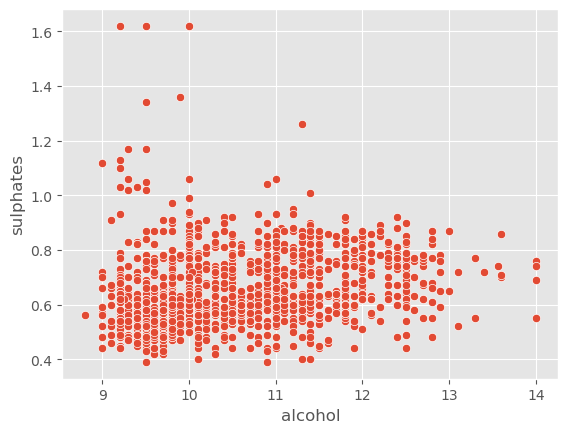

In [12]:
sns.scatterplot(x = 'alcohol', y = 'sulphates', data = test);

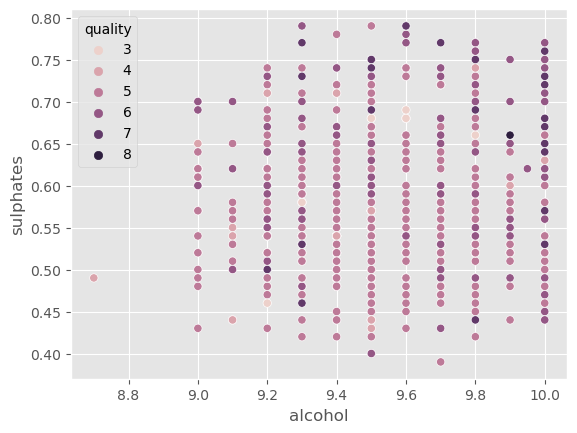

In [16]:
sns.scatterplot(x = 'alcohol', y = 'sulphates', hue = 'quality', data = train[((train['alcohol'] <= 10) & (train['sulphates'] < 0.8))]);

In [22]:
train[((train['alcohol'] <= 10) & (train['sulphates'] < 0.55))].describe()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,1040.513196,8.180645,0.608804,0.210704,2.352493,0.083944,18.586510,67.469208,0.997178,3.294751,0.504721,9.541349,5.146628
std,588.803106,1.337571,0.167381,0.153297,0.670273,0.016869,10.749582,41.371521,0.001395,0.137472,0.032254,0.246427,0.560117
min,3.000000,5.300000,0.220000,0.000000,1.300000,0.042000,3.000000,9.000000,0.991570,2.740000,0.390000,8.700000,3.000000
25%,526.000000,7.400000,0.500000,0.080000,1.900000,0.076000,10.000000,31.000000,0.996280,3.190000,0.480000,9.400000,5.000000
50%,1104.000000,7.800000,0.600000,0.220000,2.200000,0.082000,17.000000,65.000000,0.997180,3.290000,0.520000,9.500000,5.000000
75%,1525.000000,8.800000,0.700000,0.280000,2.600000,0.089000,25.000000,94.000000,0.998000,3.370000,0.530000,9.700000,5.000000
max,2054.000000,13.400000,1.330000,0.670000,5.600000,0.226000,68.000000,289.000000,1.002600,3.780000,0.540000,10.000000,7.000000


In [23]:
train['quality'].value_counts()

5    839
6    778
7    333
4     55
8     39
3     12
Name: quality, dtype: int64

In [24]:
train[((train['alcohol'] <= 10) & (train['sulphates'] < 0.55))]['quality'].value_counts()

5    263
6     50
4     16
7     10
3      2
Name: quality, dtype: int64

In [19]:
train.shape

(2056, 13)

In [ ]:
sns.scatterplot(x = 'alcohol', y = 'sulphates', hue = 'quality', data = train);

# Feature Engineering 

In [17]:
# train['alcohol_sulphates'] = train['alcohol'] * train['sulphates']
# train['acid/density'] = train['total_acid']  / train['density']
# train['pH_sulphates'] =  np.exp(train['pH'] * train['sulphates'])
train['alcohol_density'] = train['alcohol'] * train['density']
train['sulphate/density'] = train['sulphates']  / train['density']
# train['sulphates/acid'] = train['sulphates'] / train['volatile acidity']
train['mso2'] = train['free sulfur dioxide'] / (1+ 10**(train['pH'] - 1.81))

# test['alcohol_sulphates'] = test['alcohol'] * test['sulphates']
# test['acid/density'] = test['total_acid']  / test['density']
# test['pH_sulphates'] =  np.exp(test['pH'] * test['sulphates'])
test['alcohol_density'] = test['alcohol']  * test['density']
test['sulphate/density'] = test['sulphates']  / test['density']
# test['sulphates/acid'] = test['sulphates'] / test['volatile acidity']
test['mso2'] = test['free sulfur dioxide'] / (1+ 10**(test['pH'] - 1.81))

In [13]:
test.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pH_sulphates,alcohol_density,sulphate/density,mso2
0,2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8,7.389795,9.775304,0.591491,0.794486
1,2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0,9.625348,9.958600,0.682827,0.410399
2,2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5,7.403849,9.478530,0.651472,1.070289
3,2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7,8.542041,11.639160,0.653398,0.438831
4,2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8,4.713355,12.717568,0.483111,0.293012


In [14]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,alcohol_density,sulphate/density,mso2
0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,12.048212,0.773310,0.879427
1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,12.781312,0.670980,0.899298
2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,11.261580,0.732490,0.057377
3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,9.773540,0.531435,0.430577
4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,9.447180,1.367604,0.391434


In [15]:
test_md.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,pH_sulphates,alcohol_density,sulphate/density,mso2
0,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8,7.389795,9.775304,0.591491,0.794486
1,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0,9.625348,9.958600,0.682827,0.410399
2,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5,7.403849,9.478530,0.651472,1.070289
3,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7,8.542041,11.639160,0.653398,0.438831
4,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8,4.713355,12.717568,0.483111,0.293012


# XGBoost Modeling

In [21]:
test_md = test.copy()

X = train[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates']]
# X = train.drop(columns = ['Id', 'quality'], axis = 1)
Y = train['quality'] - 3
# test_md = test_md.drop(columns = 'Id', axis = 1)
test_md = test_md[['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates']]

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.75, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 5, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict(X_test)
        XGB_pred_2 = XGB_md.predict(test_md)
        
        ## Computing roc-auc score
        XGB_cv_scores.append(cohen_kappa_score(Y_test, XGB_pred_1, weights = 'quadratic'))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.5317666190241566


In [23]:
XGB_preds_test = pd.DataFrame(preds).mode(axis = 0).loc[0, ] + 3

submission['quality'] = XGB_preds_test.astype(int)
submission.head()

,Id,quality
0,2056,5
1,2057,6
2,2058,6
3,2059,6
4,2060,6


In [24]:
submission['quality'].value_counts()

6    617
5    588
7    167
Name: quality, dtype: int64

In [25]:
submission.to_csv('XGB_baseline_FE_4.csv', index = False)

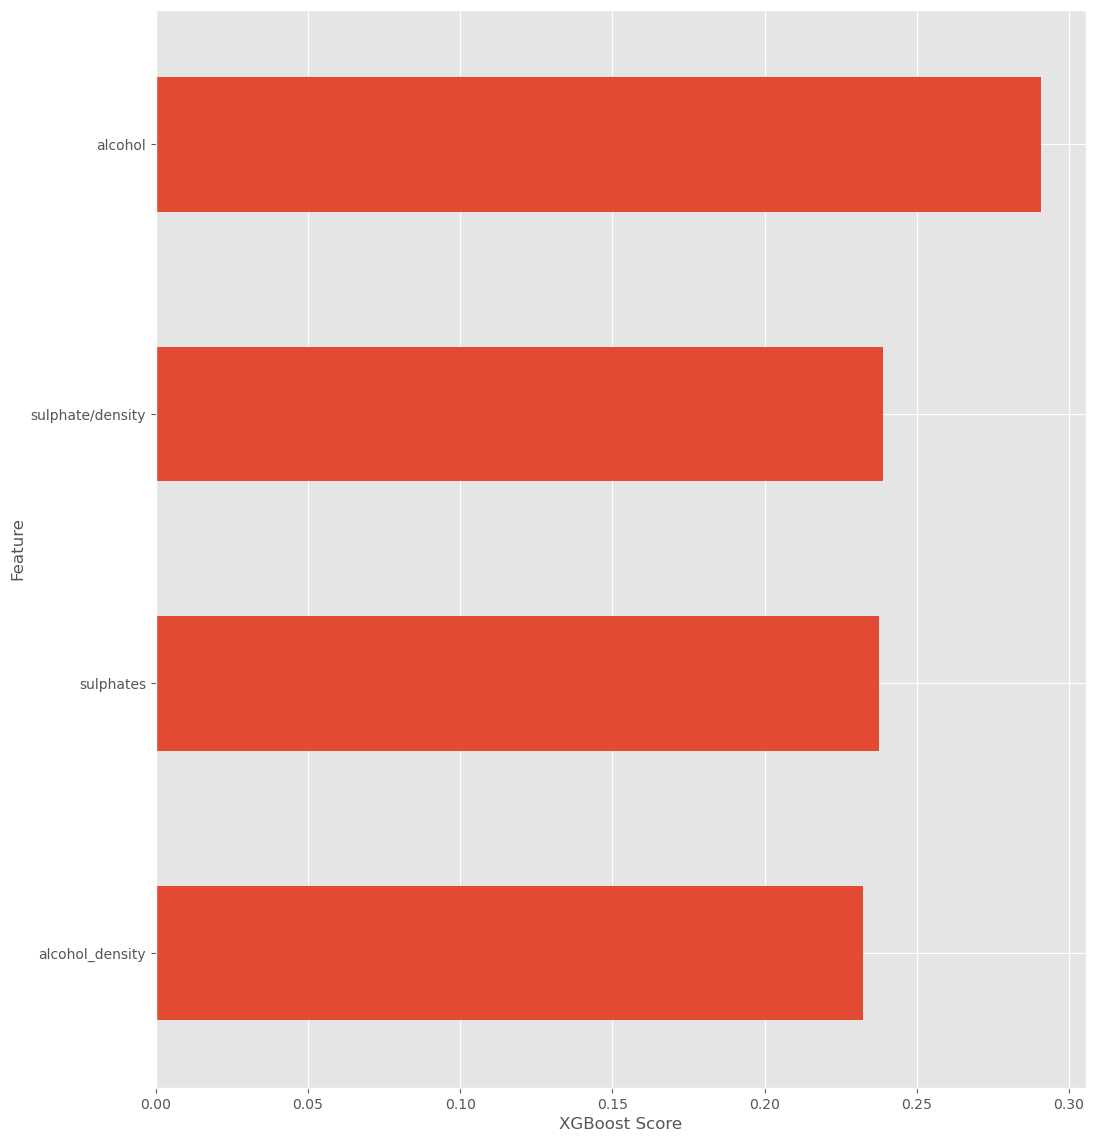

In [22]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();